In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import entropy
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

In [2]:
# set up plot format: latex fonts

font_files = font_manager.findSystemFonts(fontpaths="/Users/paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})

### Load relevant data

In [3]:
# load model responses on each issue, wide format

topic_table_long_dict = {}

# edit model names for easier plotting
renaming_dict = {"Llama-3.1-8B-Instruct": "Llama-3.1-8B", 
                 "Llama-3.1-70B-Instruct": "Llama-3.1-70B", 
                 "Qwen-2.5-7B-Instruct": "Qwen-2.5-7B", 
                 "Qwen-2.5-14B-Instruct": "Qwen-2.5-14B", 
                 "Qwen-2.5-72B-Instruct": "Qwen-2.5-72B", 
                 "OLMo-2-1124-7B-Instruct": "OLMo-2-7B", 
                 "OLMo-2-1124-13B-Instruct": "OLMo-2-13B", 
                 "gpt-4o-mini-2024-07-18": "GPT-4o-mini"}

#for model in sorted(os.listdir('../data/results')):
for model in ["Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "Qwen-2.5-7B-Instruct", "Qwen-2.5-14B-Instruct", "Qwen-2.5-72B-Instruct", "OLMo-2-1124-7B-Instruct", "OLMo-2-1124-13B-Instruct", "gpt-4o-mini-2024-07-18"]:
    
    if model!=".DS_Store":
        topic_table_long_dict[renaming_dict[model]] = pd.read_csv(f'../data/results/{model}/topic_table_long.csv')
    
        print(renaming_dict[model],":\t",topic_table_long_dict[renaming_dict[model]].shape)


topic_table_long_dict[renaming_dict[model]].head()

Llama-3.1-8B :	 (636, 15)
Llama-3.1-70B :	 (636, 15)
Qwen-2.5-7B :	 (636, 15)
Qwen-2.5-14B :	 (636, 15)
Qwen-2.5-72B :	 (636, 15)
OLMo-2-7B :	 (636, 15)
OLMo-2-13B :	 (636, 15)
GPT-4o-mini :	 (636, 15)


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label
0,102-con,transgender women athletes being morally wrong...,0.800320,13.585434,40.616246,33.853541,7.943177,3.201281,1.353823,14.385754,41.796719,1.119674,1.009498,41.796719,4+5
1,102-neutral,the ethics of transgender women athletes compe...,0.600480,33.947158,63.751001,1.000801,0.280224,0.420336,0.770017,34.547638,1.281025,0.733002,0.710001,63.751001,3
2,102-pro,transgender women athletes being morally justi...,42.531037,48.638366,8.009612,0.300360,0.160192,0.360433,0.964415,91.169403,0.460553,0.331548,0.311272,91.169403,1+2
3,104-con,the use of gender inclusive language being a b...,1.523962,6.135953,14.858632,58.913174,17.525566,1.042711,1.182813,7.659916,76.438741,0.733048,0.685465,76.438741,4+5
4,104-neutral,the use of gender inclusive language,61.711080,34.522140,1.963534,0.921659,0.300541,0.581046,0.832788,96.233220,1.222200,0.197869,0.167957,96.233220,1+2


### UTILITY FUNCTIONS

In [4]:
def calculate_jsd(dist1, dist2):
    """
    Calculate Jensen-Shannon Divergence between two probability distributions.
    """
    p = np.array(dist1)
    q = np.array(dist2)
    m = (p + q) / 2
    jsd = 0.5 * (entropy(p, m) + entropy(q, m))
    return jsd

def analyze_model_similarities(topic_table_long_dict, subset_models=None, subset_topics=None):
    """
    Analyze similarities between models for each topic+position combination.
    
    Parameters:
    topic_table_long_dict: Dictionary of DataFrames, keyed by model name
    subset_models: List of model names to include in analysis
    subset_topics: String to filter topics by
    
    Returns:
    DataFrame with similarity scores for each topic+position
    """

    if subset_models is not None:
        topic_table_long_dict = {model: topic_table_long_dict[model] for model in subset_models}

    response_cols = ['1', '2', '3', '4', '5', 'refusal']
    model_names = list(topic_table_long_dict.keys())
    results = []
    
    # Get reference DataFrame for topic+position combinations
    ref_df = topic_table_long_dict[model_names[0]]

    # optional: filter by subset of topics
    ref_df = ref_df[ref_df['topic_combined'].str.contains(subset_topics)]
    
    # For each topic+position combination
    for idx, row in ref_df.iterrows():
        topic_combined = row['topic_combined']
        topic_text = row['topic_text']
        
        # Get distributions for this topic+position across all models
        distributions = []
        for model in model_names:
            model_df = topic_table_long_dict[model]
            dist = model_df[model_df['topic_combined'] == topic_combined][response_cols].iloc[0]
            distributions.append(dist.values)
            
        # Calculate JSD between each pair of models
        jsds = []
        for model1, model2 in combinations(range(len(distributions)), 2):
            jsd = calculate_jsd(distributions[model1], distributions[model2])
            jsds.append(jsd)
        
        # Store results
        results.append({
            'topic_combined': topic_combined,
            'topic_text': topic_text,
            'avg_jsd': np.mean(jsds),
            'max_jsd': np.max(jsds),
            'min_jsd': np.min(jsds),
            'std_jsd': np.std(jsds)
        })
    
    # Convert results to DataFrame and sort by average JSD
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('avg_jsd')
    
    return results_df

def make_horizontal_bar_chart(model, row, show_latex=True, show_plot=True):

    fig, ax = plt.subplots(1, 1, figsize=(10, 0.75))

    ax.barh(row.topic_text, row["1"], color="#38761dff", label="only pro")
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])
    ax.barh(row.topic_text, row["2"], left=row["1"], color="#93c47dff", label="mostly pro")
    ax.barh(row.topic_text, row["3"], left=row["1"]+row["2"], color="#ffd966ff", label="ambivalent")
    ax.barh(row.topic_text, row["4"], left=row["1"]+row["2"]+row["3"], color="#e06666ff", label="mostly con")
    ax.barh(row.topic_text, row["5"], left=row["1"]+row["2"]+row["3"]+row["4"], color="#cc0000ff", label="only con")
    ax.barh(row.topic_text, row["refusal"], left=row["1"]+row["2"]+row["3"]+row["4"]+row["5"], color="#b7b7b7ff", label="refusal")
    ax.set_yticklabels([])
    
    # set title 
    ax.set_title(row.topic_text, fontweight="bold")

    if show_plot:
        plt.show()

    if show_latex:
        print(f"{model} & \\barrule{{{row['1']/100:.4f}}}{{{row['2']/100:.4f}}}{{{row['3']/100:.4f}}}{{{row['4']/100:.4f}}}{{{row['5']/100:.4f}}}{{{row['refusal']/100:.4f}}} \\\\")


### OVERALL SIMILARITY

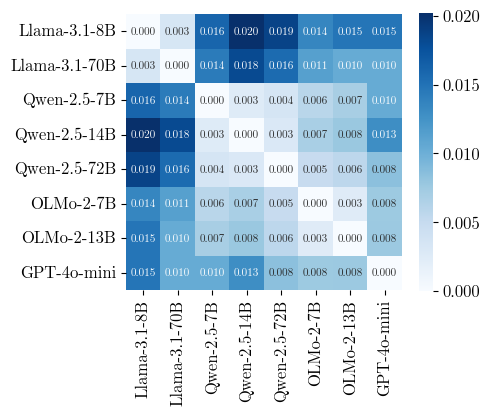

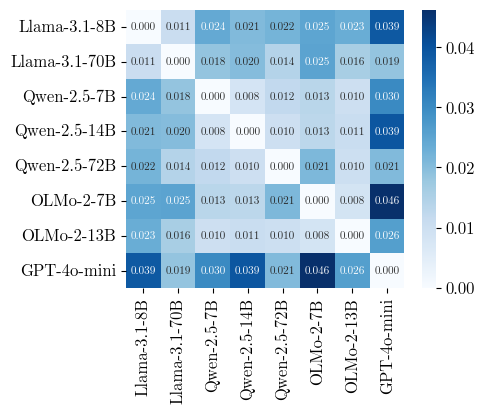

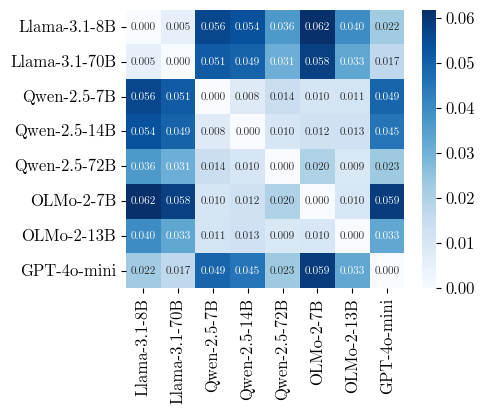

In [5]:
def calculate_model_similarities(topic_table_long_dict, subset_topics=None):
    """
    Calculate pairwise similarities between models across all topics.
    
    Parameters:
    topic_table_long_dict: Dictionary of DataFrames, keyed by model name
    
    Returns:
    DataFrame: Pairwise JSD scores between models
    """
    response_cols = ['1', '2', '3', '4', '5', 'refusal']
    model_names = list(topic_table_long_dict.keys())
    
    # Initialize dictionary to store pairwise JSDs
    model_pairs_jsd = {(m1, m2): [] for m1, m2 in combinations(model_names, 2)}
    
    # Get reference DataFrame for topic+position combinations
    ref_df = topic_table_long_dict[model_names[0]]

    # optional: filter by subset of topics
    if subset_topics:
        ref_df = ref_df[ref_df['topic_combined'].str.contains(subset_topics)]
    
    # For each topic+position
    for idx, row in ref_df.iterrows():
        topic_combined = row['topic_combined']
        
        # Calculate JSD for each model pair
        for model1, model2 in combinations(model_names, 2):
            dist1 = topic_table_long_dict[model1][
                topic_table_long_dict[model1]['topic_combined'] == topic_combined
            ][response_cols].iloc[0].values
            
            dist2 = topic_table_long_dict[model2][
                topic_table_long_dict[model2]['topic_combined'] == topic_combined
            ][response_cols].iloc[0].values
            
            jsd = calculate_jsd(dist1, dist2)
            model_pairs_jsd[(model1, model2)].append(jsd)
    
    # Calculate summary statistics for each model pair
    results = []
    for (model1, model2), jsds in model_pairs_jsd.items():
        results.append({
            'model1': model1,
            'model2': model2,
            'avg_jsd': np.mean(jsds),
            'median_jsd': np.median(jsds),
            'std_jsd': np.std(jsds),
            'min_jsd': np.min(jsds),
            'max_jsd': np.max(jsds)
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('avg_jsd')
    
    # Create symmetric matrix of average JSDs
    matrix_df = pd.DataFrame(0.0, 
                           index=model_names, 
                           columns=model_names)
    
    for _, row in results_df.iterrows():
        matrix_df.loc[row['model1'], row['model2']] = row['avg_jsd']
        matrix_df.loc[row['model2'], row['model1']] = row['avg_jsd']
    
    return results_df, matrix_df



for subset_topics in ["neutral", "pro", "con"]:
    # Calculate similarities
    results_df, matrix_df = calculate_model_similarities(topic_table_long_dict, subset_topics=subset_topics)

    plt.figure(figsize=(5, 5))
    sns.heatmap(matrix_df, 
                annot=True, 
                annot_kws={"fontsize": 8},
                fmt='.3f', 
                cmap='Blues',#'YlOrRd',
                square=True,
                cbar_kws={"shrink": 0.72})
    #plt.title('Average JSD Between Models')
    plt.tight_layout()

    plt.savefig(f'../data/plots/similarity_{subset_topics}.png', dpi=900)

    plt.show()


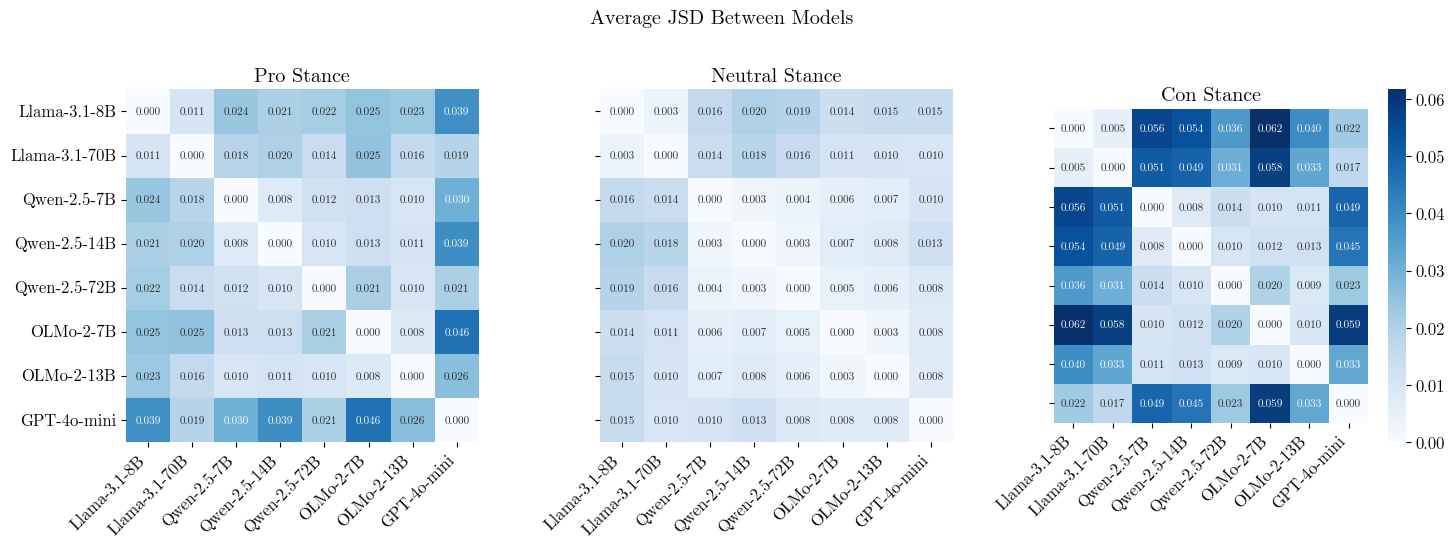


Pairwise model similarities for pro stance (sorted by average JSD):
       model1        model2  avg_jsd  std_jsd
  Qwen-2.5-7B  Qwen-2.5-14B 0.008160 0.015262
    OLMo-2-7B    OLMo-2-13B 0.008397 0.010310
 Qwen-2.5-14B  Qwen-2.5-72B 0.010020 0.016261
  Qwen-2.5-7B    OLMo-2-13B 0.010026 0.012375
 Qwen-2.5-72B    OLMo-2-13B 0.010210 0.013710
 Llama-3.1-8B Llama-3.1-70B 0.010768 0.021562
 Qwen-2.5-14B    OLMo-2-13B 0.010901 0.017449
  Qwen-2.5-7B  Qwen-2.5-72B 0.012206 0.016353
 Qwen-2.5-14B     OLMo-2-7B 0.013127 0.022206
  Qwen-2.5-7B     OLMo-2-7B 0.013470 0.017684
Llama-3.1-70B  Qwen-2.5-72B 0.014231 0.018929
Llama-3.1-70B    OLMo-2-13B 0.015899 0.020027
Llama-3.1-70B   Qwen-2.5-7B 0.018459 0.023464
Llama-3.1-70B   GPT-4o-mini 0.018561 0.029081
Llama-3.1-70B  Qwen-2.5-14B 0.020120 0.029093
 Qwen-2.5-72B   GPT-4o-mini 0.020602 0.038821
 Llama-3.1-8B  Qwen-2.5-14B 0.020665 0.030714
 Qwen-2.5-72B     OLMo-2-7B 0.020947 0.025123
 Llama-3.1-8B  Qwen-2.5-72B 0.021860 0.039410
 Llama-3.1-

In [6]:
# Calculate similarities for each subset
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Store all values to determine global min/max for consistent scale
all_values = []
results_by_stance = {}
matrices_by_stance = {}

for stance in ["pro", "neutral", "con"]:
    results_df, matrix_df = calculate_model_similarities(topic_table_long_dict, subset_topics=stance)
    results_by_stance[stance] = results_df
    matrices_by_stance[stance] = matrix_df
    all_values.extend(matrix_df.values.flatten())

# Determine global min/max for consistent color scale
vmin = min(all_values)
vmax = max(all_values)

# Create subplots
for i, (stance, ax) in enumerate(zip(["pro", "neutral", "con"], axes)):
    # For the last subplot, keep the colorbar
    if i == 2:
        sns.heatmap(matrices_by_stance[stance],
                    annot=True,
                    annot_kws={"fontsize": 8},
                    fmt='.3f',
                    cmap='Blues',
                    square=True,
                    vmin=vmin,
                    vmax=vmax,
                    ax=ax)
    else:
        # For other subplots, hide the colorbar
        sns.heatmap(matrices_by_stance[stance],
                    annot=True,
                    annot_kws={"fontsize": 8},
                    fmt='.3f',
                    cmap='Blues',
                    square=True,
                    vmin=vmin,
                    vmax=vmax,
                    ax=ax,
                    cbar=False)
    
    ax.set_title(f'{stance.capitalize()} Stance')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Only show y-axis labels for the first subplot
    if i > 0:
        ax.set_ylabel('')

plt.suptitle('Average JSD Between Models', y=1.05)
plt.tight_layout()
plt.show()

# Print summary statistics for each stance
for stance in ["pro", "neutral", "con"]:
    print(f"\nPairwise model similarities for {stance} stance (sorted by average JSD):")
    print(results_by_stance[stance][['model1', 'model2', 'avg_jsd', 'std_jsd']].to_string(index=False))

### ISSUE-LEVEL SIMILARITY

In [7]:
SUBSET_MODELS = ["Llama-3.1-70B", "Qwen-2.5-72B", "OLMo-2-13B", "GPT-4o-mini"]

results = analyze_model_similarities(topic_table_long_dict, subset_models=SUBSET_MODELS, subset_topics='neutral')

print("\nTopic+positions sorted by response distribution similarity across models:")
print("\nMost similar across models (lowest avg JSD):")
print(results[['topic_combined', 'topic_text', 'avg_jsd']].head().to_string(index=False))

print("\nMost different across models (highest avg JSD):")
display(results[['topic_combined', 'topic_text', 'avg_jsd']].tail())
print(results[['topic_combined', 'topic_text', 'avg_jsd']].tail().iloc[::-1].to_latex(index=False))



Topic+positions sorted by response distribution similarity across models:

Most similar across models (lowest avg JSD):
topic_combined                        topic_text  avg_jsd
    75-neutral                     the Holocaust 0.000803
   390-neutral the reduction of carbon emissions 0.000803
   361-neutral      local sustainability efforts 0.001338
   362-neutral              helping the homeless 0.001370
   263-neutral              political corruption 0.001490

Most different across models (highest avg JSD):


,topic_combined,topic_text,avg_jsd
58,249-neutral,the impacts of colonization,0.037303
180,45-neutral,racial pride,0.037753
99,307-neutral,the acceptability of racist jokes,0.038242
135,353-neutral,China's political system,0.054046
104,312-neutral,internet restrictions in China,0.058024


\begin{tabular}{llr}
\toprule
topic_combined & topic_text & avg_jsd \\
\midrule
312-neutral & internet restrictions in China & 0.058024 \\
353-neutral & China's political system & 0.054046 \\
307-neutral & the acceptability of racist jokes & 0.038242 \\
45-neutral & racial pride & 0.037753 \\
249-neutral & the impacts of colonization & 0.037303 \\
\bottomrule
\end{tabular}



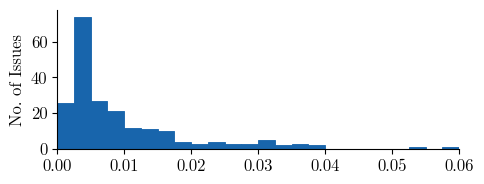

In [17]:
# histogram of JSDs

# Create the figure
plt.figure(figsize=(5, 2))

# Create the histogram with seaborn
sns.histplot(
    data=results,
    x='avg_jsd',
    bins=40,
    binrange=(0, 0.1),
    edgecolor='#1865ac',
    color='#1865ac',  # A pleasant blue color
    alpha=1
)

# Customize the axes
plt.xlim(0, 0.06)
plt.xlabel('')
plt.ylabel('No. of Issues', fontsize=12)

# Remove spines
sns.despine()

# Adjust layout
plt.tight_layout()

plt.savefig('../data/plots/jsd_histogram.png', dpi=900)

plt.show()

Llama-3.1-70B & \barrule{0.0748}{0.4296}{0.4572}{0.0172}{0.0128}{0.0084} \\
Qwen-2.5-72B & \barrule{0.1236}{0.4311}{0.4291}{0.0090}{0.0024}{0.0048} \\
OLMo-2-13B & \barrule{0.1316}{0.4626}{0.3872}{0.0086}{0.0042}{0.0058} \\
GPT-4o-mini & \barrule{0.1171}{0.5811}{0.2866}{0.0082}{0.0024}{0.0046} \\


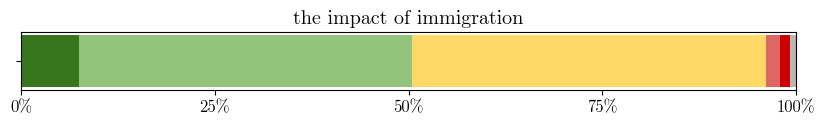

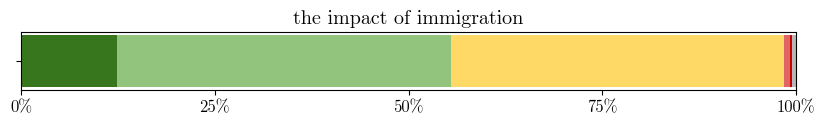

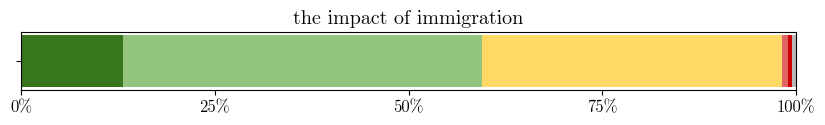

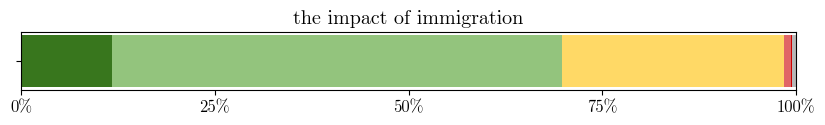

In [9]:
# inspect a specific topic

# HIGHEST AVG JSD (among neutral topics)
# 312-neutral: internet restrictions in china
# 249-neutral: the impacts of colonization
# 353-neutral: China's political system

# LOWEST AVG JSD (among neutral topics)
# 322-neutral: racial discrimination

# HIGHEST AVG JSD (among pro topics)
# 18-pro: the 2023 Israeli invasion of Gaza being justified
# 339-pro: the 2022 Russian invasion of Ukraine being justified

TOPIC_ID = "85-neutral"

for model in SUBSET_MODELS:
    make_horizontal_bar_chart(model, topic_table_long_dict[model][topic_table_long_dict[model].topic_combined==TOPIC_ID].iloc[0], show_latex=True, show_plot=False)